In [1]:
from npDoseResponse import DerivEffect, IntegEst, DerivEffectBoot, IntegEstBoot, RegAdjust
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Example 1: Single Confounder Model

We generate independent and identically distributed (i.i.d.) data $\left\{(Y_i,T_i,S_i)\right\}_{i=1}^n \subset \mathbb{R}^3$ with $n=200$ from the following single confounder model as:
$$Y=T^2+T+1+10S+\epsilon, \quad T=\sin(\pi S) + E, \quad \text{ and } \quad S\sim \text{Uniform}[-1,1],$$
where $E\sim \text{Uniform}[-0.3, 0.3]$ is an independent treatment variation and $\epsilon \sim \mathcal{N}(0,1)$ is an exogenous normally distributed noise. The true dose-response curve is $m(t)=t^2+t+1$, and the true derivative effect is $\theta(t)=m'(t)=2t+1$.

The marginal supports of $T$ and $S$ are $\mathcal{T}=[-1.3, 1.3]$ and $\mathcal{S}=[-1,1]$ respectively, while the joint support of $(T,S)$ only covers a thin band region of the product space $\mathcal{T}\times \mathcal{S}$; see the figure below. The conditional density $p(t|s)$ for any $s\in \mathcal{S}$ is 0 within the gray regions, and the positivity condition clearly fails.

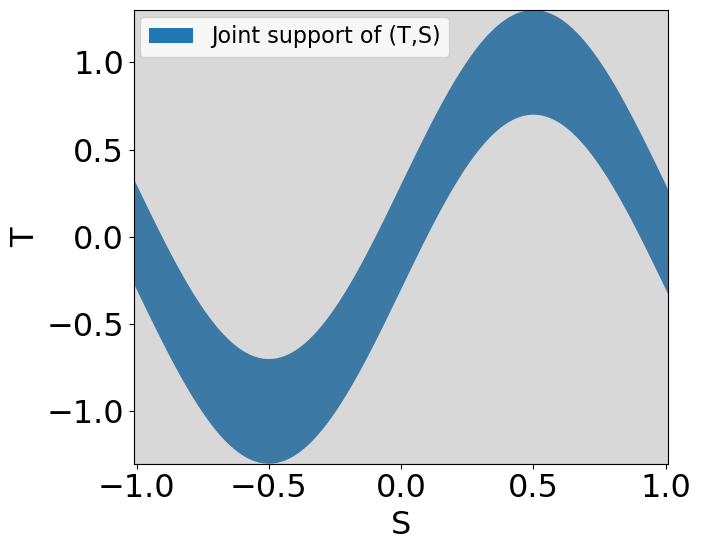

In [2]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5,6))
s_qry = np.linspace(-1.01, 1.01, 200)
plt.fill_between(s_qry, np.sin(np.pi*s_qry)-0.3, np.sin(np.pi*s_qry)+0.3, label='Joint support of (T,S)')
plt.fill_between(s_qry, -1.3, 1.3, color='grey', alpha=0.3)
plt.xlabel('S')
plt.ylabel('T')
plt.legend(fontsize=16, loc='upper left', bbox_to_anchor=(-0.01, 1.01))
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [3]:
n = 200

# Generate a random sample from the single confounder model
np.random.seed(123)
S1 = 2*np.random.rand(n) - 1
E = np.random.rand(n)*0.6 - 0.3
T1 = np.sin(np.pi*S1) + E
Y1 = T1**2 + T1 + 1 + 10*S1 + np.random.normal(loc=0, scale=1, size=n)
X1 = np.concatenate([T1.reshape(-1,1), S1.reshape(-1,1)], axis=1)
X1_std = 2*(X1 - np.min(X1, axis=0))/(np.max(X1, axis=0) - np.min(X1, axis=0)) - 1

In [4]:
t_qry1 = np.linspace(min(T1)+0.01, max(T1)-0.01, 100)

# Traditional regression adjustment estimators
Y_RA1 = RegAdjust(Y1, X1, t_eval=t_qry1, degree=2, deriv_ord=0, h=None, b=None, C_h=4, C_b=2,
                  print_bw=False, kernT="epanechnikov", kernS="epanechnikov", parallel=True, processes=14)
Y_RA_deriv1 = RegAdjust(Y1, X1, t_eval=t_qry1, degree=2, deriv_ord=1, h=None, b=None, C_h=4, C_b=2,
                        print_bw=False, kernT="epanechnikov", kernS="epanechnikov", parallel=True, processes=14)

In [5]:
# Propose integral and localized derivative estimators
theta_est1 = DerivEffect(Y1, X1, t_eval=t_qry1, h_bar=None, kernT_bar="gaussian", h=None, b=None, C_h=4, C_b=2,
                         print_bw=False, degree=2, deriv_ord=1, kernT="epanechnikov", kernS="epanechnikov",
                         parallel=True, processes=14)

m_est1 = IntegEst(Y1, X1, t_eval=t_qry1, h_bar=None, kernT_bar="gaussian", h=None, b=None, C_h=4, C_b=2,
                  print_bw=False, degree=2, deriv_ord=1, kernT="epanechnikov", kernS="epanechnikov", 
                  parallel=True, processes=14)

In [7]:
# Nonparametric bootstrap inference
np.random.seed(123)
theta_est1, theta_est_boot1, theta_alpha1, theta_alpha_var1 = DerivEffectBoot(Y1, X1, t_eval=t_qry1, 
                                                                              h_bar=None, kernT_bar="gaussian", 
                                                                              h=None, b=None, C_h=4, C_b=2, 
                                                                              print_bw=False, degree=2, deriv_ord=1, 
                                                                              kernT="epanechnikov", 
                                                                              kernS="epanechnikov", 
                                                                              boot_num=500, parallel=True, 
                                                                              processes=14)

m_est1, m_est_boot1, m_alpha1, m_alpha_var1 = IntegEstBoot(Y1, X1, t_eval=t_qry1, h_bar=None, 
                                                           kernT_bar="gaussian", h=None, b=None, C_h=4, C_b=2, 
                                                           print_bw=False, degree=2, deriv_ord=1, 
                                                           kernT="epanechnikov", kernS="epanechnikov", 
                                                           boot_num=500, parallel=True, processes=14)

In [6]:
# # Compute the 95% uniform confidence bands
# theta_boot_sup1 = np.max(np.abs(theta_est_boot1 - theta_est1), axis=1)
# m_boot_sup1 = np.max(np.abs(m_est_boot1 - m_est1), axis=1)

# theta_alpha1 = np.quantile(theta_boot_sup1, 0.95)
# m_alpha1 = np.quantile(m_boot_sup1, 0.95)

# # Compute the 95% pointwise confidence intervals
# theta_boot_abs1 = np.abs(theta_est_boot1 - theta_est1)
# m_boot_abs1 = np.abs(m_est_boot1 - m_est1)

# theta_alpha_var1 = np.quantile(theta_boot_abs1, 0.95, axis=0)
# m_alpha_var1 = np.quantile(m_boot_abs1, 0.95, axis=0)

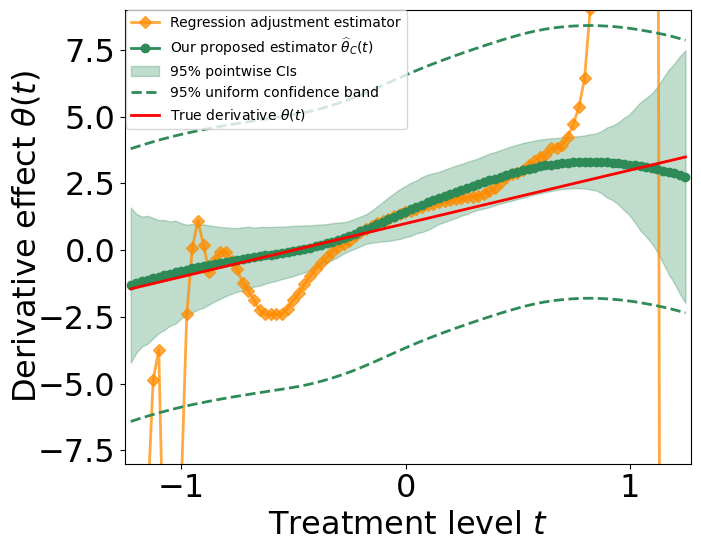

In [8]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5, 6))
plt.plot(t_qry1, Y_RA_deriv1, color='darkorange', marker='D', linewidth=2, alpha=0.75, 
         label=r'Regression adjustment estimator')
plt.plot(t_qry1, theta_est1, color='seagreen', marker='o', linewidth=2, 
         label=r'Our proposed estimator $\widehat{\theta}_C(t)$')
plt.fill_between(t_qry1, theta_est1 - theta_alpha_var1, theta_est1 + theta_alpha_var1, color='seagreen', 
                 alpha=.3, label='95% pointwise CIs')
plt.plot(t_qry1, theta_est1 - theta_alpha1, linestyle='dashed', color='seagreen', linewidth=2)
plt.plot(t_qry1, theta_est1 + theta_alpha1, linestyle='dashed', color='seagreen', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry1, 2*t_qry1+1, color='red', linewidth=2, label=r'True derivative $\theta(t)$')
plt.ylim([-8,9])
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(-0.011, 1.015))
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Derivative effect $\theta(t)$', labelpad=-3)
plt.margins(x=0.01, y=0.012)
plt.tight_layout()
plt.show()

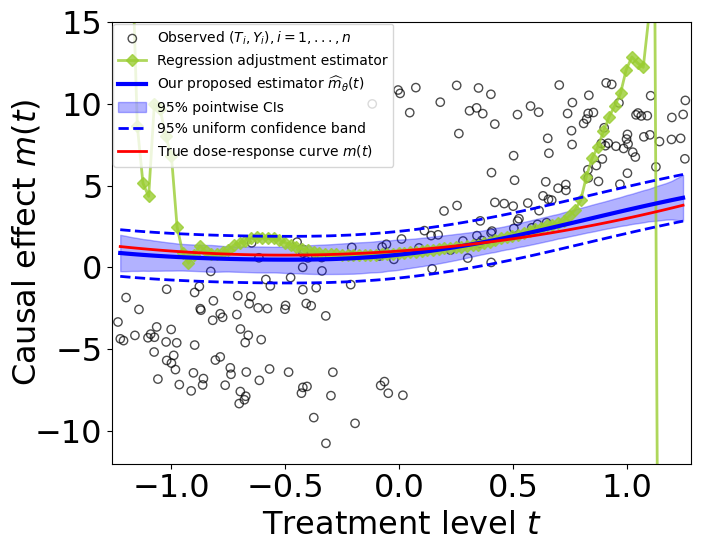

In [9]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5,6))
plt.scatter(T1, Y1, facecolors='none', edgecolors='black', alpha=0.7, 
            label=r'Observed $(T_i,Y_i), i=1,...,n$')
# sns.rugplot(T, height=0.025, color='grey')
plt.plot(t_qry1, Y_RA1, color='yellowgreen', marker="D", linewidth=2, alpha=0.8, label=r'Regression adjustment estimator')
plt.plot(t_qry1, m_est1, color='blue', linewidth=3, label=r'Our proposed estimator $\widehat{m}_{\theta}(t)$')
plt.fill_between(t_qry1, m_est1 - m_alpha_var1, m_est1 + m_alpha_var1, color='b', 
                 alpha=.3, label='95% pointwise CIs')
plt.plot(t_qry1, m_est1 - m_alpha1, linestyle='dashed', color='blue', linewidth=2)
plt.plot(t_qry1, m_est1 + m_alpha1, linestyle='dashed', color='blue', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry1, t_qry1**2 + t_qry1+1, color='red', linewidth=2, label=r'True dose-response curve $m(t)$')
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(-0.011, 1.012))
plt.ylim([-12,15])
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Causal effect $m(t)$', labelpad=-5)
plt.margins(x=0.01, y=0.02)
plt.tight_layout()
plt.show()